## GROUP B ASSIGNMENT 
### Pyspark Data Analysis Application - Classified Ads for Cars

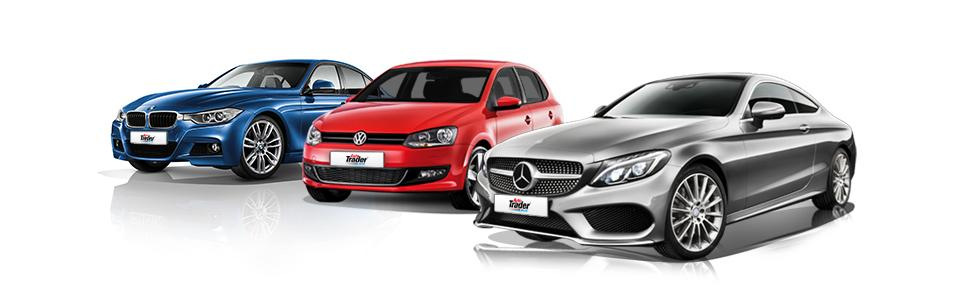

In this exercise we will use Classified Ads for Cars dataset from Kaggle: https://www.kaggle.com/mirosval/personal-cars-classifieds/data

We have selected one dataset that could allow us to implement all the requirements of the final project. The data was scraped from several websites in Czech Republic and Germany over a period of more than a year. With this data the goal is to create a model that can predict the price classification of the cars given certain variables. 

There are roughly 3,5 Million rows and the following columns.

##### Variable definition
* maker - normalized all lowercase
* model - normalized all lowercase
* mileage - in KM
* manufacture_year
* engine_displacement - in ccm
* engine_power - in kW
* body_type - almost never present, scraped only personal cars, no motorcycles or utility vehicles
* color_slug - also almost never present


* stk_year - year of the last emission control
* transmission - automatic or manual
* door_count
* seat_count
* fuel_type - gasoline, diesel, cng, lpg, electric
* date_created - when the ad was scraped
* date_last_seen - when the ad was last seen. Our policy was to remove all ads older than 60 days
* price_eur - list price converted to EUR

#### 0 - Preparing the Environment
As a first step, we have created a new Spark session and context to load and analyze the data. 

In [1]:
import os
os.environ["SPARK_HOME"] = "/usr/hdp/2.6.2.0-205/spark2"
os.environ["PYSPARK_PYTHON"]="/usr/bin/python3.6"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"]="notebook"

In [2]:
#Create a new spark session & context
from pyspark import SparkContext
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("ClassifiedAdsforCarsYARN") \
    .master("yarn") \
    .enableHiveSupport() \
    .getOrCreate()

sc = spark.sparkContext

In [3]:
conf=sc.getConf()
conf.get('spark.submit.deployMode')

'client'

In [4]:
from pixiedust import display
import seaborn as sns
import time
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import pandas as pd

from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import *

from pyspark.ml.feature import *
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


In [19]:
#source https://gist.github.com/joshlk/871d58e01417478176e7
def _map_to_pandas(rdds):
    """ Needs to be here due to pickling issues """
    return [pd.DataFrame(list(rdds))]

def toPandas(df, n_partitions=None):
    """
    Returns the contents of `df` as a local `pandas.DataFrame` in a speedy fashion. The DataFrame is
    repartitioned if `n_partitions` is passed.
    :param df:              pyspark.sql.DataFrame
    :param n_partitions:    int or None
    :return:                pandas.DataFrame
    """
    if n_partitions is not None: df = df.repartition(n_partitions)
    df_pand = df.rdd.mapPartitions(_map_to_pandas).collect()
    df_pand = pd.concat(df_pand)
    df_pand.columns = df.columns
    return df_pand

### 1 - LOADING THE DATASET

After understanding the variables we have developed a Pyspark Data Analysis application. 


In [5]:
hdfsHost="34.249.5.92"
Raw_DF = spark.read.csv("hdfs://"+hdfsHost+"/user/teamb/project/all_anonymized_2015_11_2017_03_v2.csv",header=True, inferSchema=True)

In [7]:
#display(Raw_DF)
Raw_DF.show(3)

+-----+-------+-------+----------------+-------------------+------------+---------+----------+--------+------------+----------+----------+---------+--------------------+--------------------+---------+
|maker|  model|mileage|manufacture_year|engine_displacement|engine_power|body_type|color_slug|stk_year|transmission|door_count|seat_count|fuel_type|        date_created|      date_last_seen|price_eur|
+-----+-------+-------+----------------+-------------------+------------+---------+----------+--------+------------+----------+----------+---------+--------------------+--------------------+---------+
| ford| galaxy| 151000|            2011|               2000|         103|     null|      null|    None|         man|         5|         7|   diesel|2015-11-14 18:10:...|2016-01-27 20:40:...| 10584.75|
|skoda|octavia| 143476|            2012|               2000|          81|     null|      null|    None|         man|         5|         5|   diesel|2015-11-14 18:10:...|2016-01-27 20:40:...|  8882

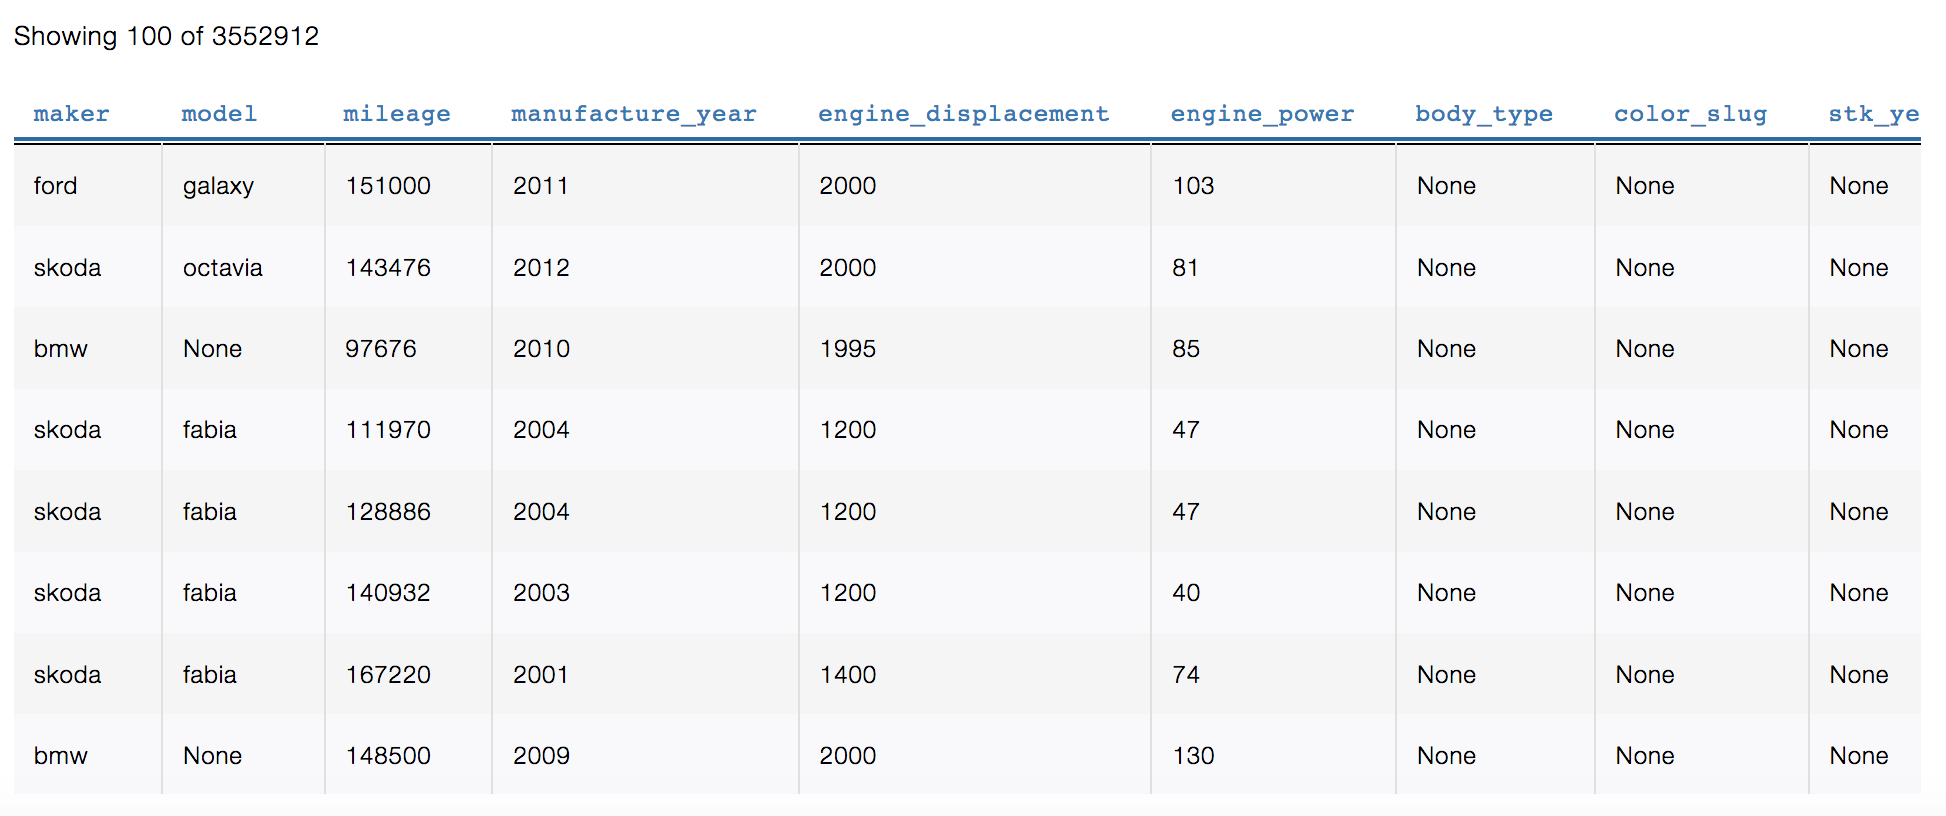

We have built an index by adding an id to identify each one of the rows. 

In [8]:
def addUniqueOrderedID(dfNoIndex):
    newSchema = StructType([StructField("id", IntegerType(), False)]\
                           + dfNoIndex.schema.fields)
    return dfNoIndex.rdd.zipWithIndex().map(lambda t: {k:v for k, v 
                              in list(t[0].asDict().items()) + [("id", t[1])]})\
                              .toDF(newSchema)
Raw_DF = addUniqueOrderedID(Raw_DF)
Raw_DF.cache()


DataFrame[id: int, maker: string, model: string, mileage: int, manufacture_year: int, engine_displacement: int, engine_power: int, body_type: string, color_slug: string, stk_year: string, transmission: string, door_count: string, seat_count: string, fuel_type: string, date_created: string, date_last_seen: string, price_eur: double]

We have dropped some of the variables that we will not be using on the analysis as body type, color slug, stk_year, among others. 

In [9]:
Cars_DF = Raw_DF.drop('body_type', 'color_slug',
                      'stk_year','date_created','date_last_seen')

Cars_DF.cache()
Raw_DF.unpersist()


DataFrame[id: int, maker: string, model: string, mileage: int, manufacture_year: int, engine_displacement: int, engine_power: int, body_type: string, color_slug: string, stk_year: string, transmission: string, door_count: string, seat_count: string, fuel_type: string, date_created: string, date_last_seen: string, price_eur: double]

In [21]:
#display(Cars_DF)
Cars_DF.show(3)

+---+-----+-------+-------+----------------+-------------------+------------+------------+----------+----------+---------+---------+
| id|maker|  model|mileage|manufacture_year|engine_displacement|engine_power|transmission|door_count|seat_count|fuel_type|price_eur|
+---+-----+-------+-------+----------------+-------------------+------------+------------+----------+----------+---------+---------+
|  0| ford| galaxy| 151000|            2011|               2000|         103|         man|         5|         7|   diesel| 10584.75|
|  1|skoda|octavia| 143476|            2012|               2000|          81|         man|         5|         5|   diesel|  8882.31|
|  2|  bmw|   null|  97676|            2010|               1995|          85|         man|         5|         5|   diesel| 12065.06|
+---+-----+-------+-------+----------------+-------------------+------------+------------+----------+----------+---------+---------+
only showing top 3 rows



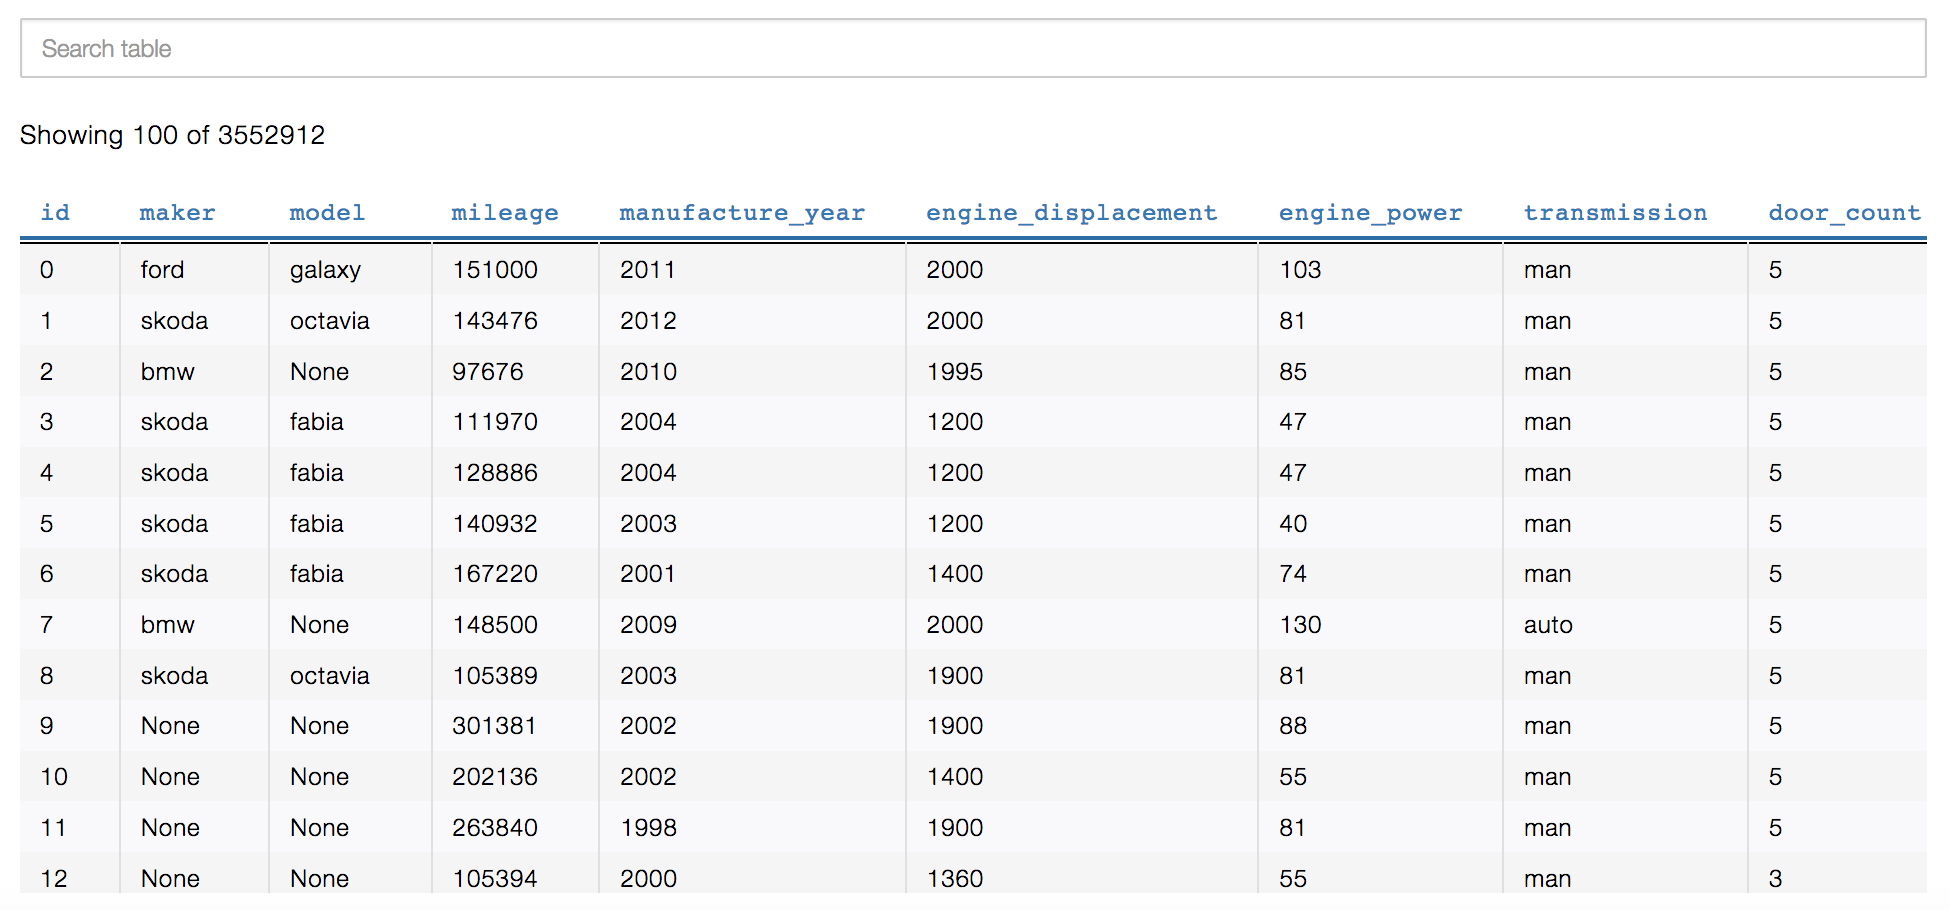

### 2 - PREPROCESSING DATA

As a next step before running into feature engineering and modeling, we need to clean and prepare the data to be ready for the next steps.

In [12]:
Cars_DF.printSchema()

root
 |-- id: integer (nullable = false)
 |-- maker: string (nullable = true)
 |-- model: string (nullable = true)
 |-- mileage: integer (nullable = true)
 |-- manufacture_year: integer (nullable = true)
 |-- engine_displacement: integer (nullable = true)
 |-- engine_power: integer (nullable = true)
 |-- transmission: string (nullable = true)
 |-- door_count: string (nullable = true)
 |-- seat_count: string (nullable = true)
 |-- fuel_type: string (nullable = true)
 |-- price_eur: double (nullable = true)



A very important step is to have the variables classified correctly as string, integers, etc. We have reclassified some variables to integers as door count to have them ready for the next stages of analysis.

In [13]:
Cars_DF = Cars_DF.withColumn("door_count", Cars_DF["door_count"].cast(IntegerType()))
Cars_DF = Cars_DF.withColumn("seat_count", Cars_DF["seat_count"].cast(IntegerType()))
Cars_DF.printSchema()

root
 |-- id: integer (nullable = false)
 |-- maker: string (nullable = true)
 |-- model: string (nullable = true)
 |-- mileage: integer (nullable = true)
 |-- manufacture_year: integer (nullable = true)
 |-- engine_displacement: integer (nullable = true)
 |-- engine_power: integer (nullable = true)
 |-- transmission: string (nullable = true)
 |-- door_count: integer (nullable = true)
 |-- seat_count: integer (nullable = true)
 |-- fuel_type: string (nullable = true)
 |-- price_eur: double (nullable = true)



### 2.1 Exploratory Analysis  

We have done a statistical summary of the numeric and string variables to learn some basic statistical measurements from them. 

#### Numeric variables description

In [ ]:
#display(Cars_DF.describe('mileage','manufacture_year',\
#                         'engine_displacement','engine_power',\
#                         'door_count','seat_count','price_eur'))

In [17]:
Cars_DF.describe('mileage','manufacture_year',\
                         'engine_displacement','engine_power',\
                         'door_count','seat_count','price_eur').toPandas()

,summary,mileage,manufacture_year,engine_displacement,engine_power,door_count,seat_count,price_eur
0,count,3190328,3182334,2809498,2998035,2462846,2265813,3552912
1,mean,115814.00227218017,2000.8712130781998,2043.9577486796575,98.46796051413676,4.052180282486197,4.869694454043648,1625811.8688977303
2,stddev,342250.7670462713,81.7258752868822,1973.9577413092077,49.073086959490816,0.9911849572791085,1.2126106264269834,2.025621942596768E9
3,min,0,0,0,1,0,0,0.04
4,max,9999999,2017,32767,2237,77,517,2.7061490530644E12


##### Exploring correlation between the dependant variable (price_eur) and each numeric variables
After exploring the correlations of each one of them we can see that there is no strong correlation between the price and some variables like mileage, engine_power, door_count, seat_count, and manufacture_year. which may alert us to work more on cleaning the dataset

In [31]:
DB = Cars_DF.drop('id','model','maker','transmission','fuel_type')
DB.cache()
DB = DB.toPandas()
DB.corr()

,mileage,manufacture_year,engine_displacement,engine_power,door_count,seat_count,price_eur
mileage,1.000000,-0.037207,0.121294,-0.006331,0.022983,0.022569,-0.000188
manufacture_year,-0.037207,1.000000,-0.044598,0.033741,0.175522,0.033145,-0.000004
engine_displacement,0.121294,-0.044598,1.000000,0.363279,-0.053402,-0.031108,0.003932
engine_power,-0.006331,0.033741,0.363279,1.000000,-0.067178,-0.036126,0.000573
door_count,0.022983,0.175522,-0.053402,-0.067178,1.000000,0.304062,-0.003450
seat_count,0.022569,0.033145,-0.031108,-0.036126,0.304062,1.000000,-0.001692
price_eur,-0.000188,-0.000004,0.003932,0.000573,-0.003450,-0.001692,1.000000


##### Data visualization: Boxplot for numeric variables

We have decided to use boxplots to represent graphically the quartiles of each one of our numerical variables. The box plot indicates variability outside the upper and lower quartiles. As we can see on our box plots we can clearly identify the outliers as individual points. 

In [32]:
pl.ioff()
pl.isinteractive()
plt.figure(figsize=(20,10),dpi=80)
plt.subplot(331)
DB.boxplot('mileage')
plt.subplot(332)
DB.boxplot('manufacture_year')
plt.subplot(333)
DB.boxplot('engine_displacement')
plt.subplot(334)
DB.boxplot('engine_power')
plt.subplot(335)
DB.boxplot('door_count')
plt.subplot(336)
DB.boxplot('seat_count')
plt.subplot(337)
DB.boxplot('price_eur')

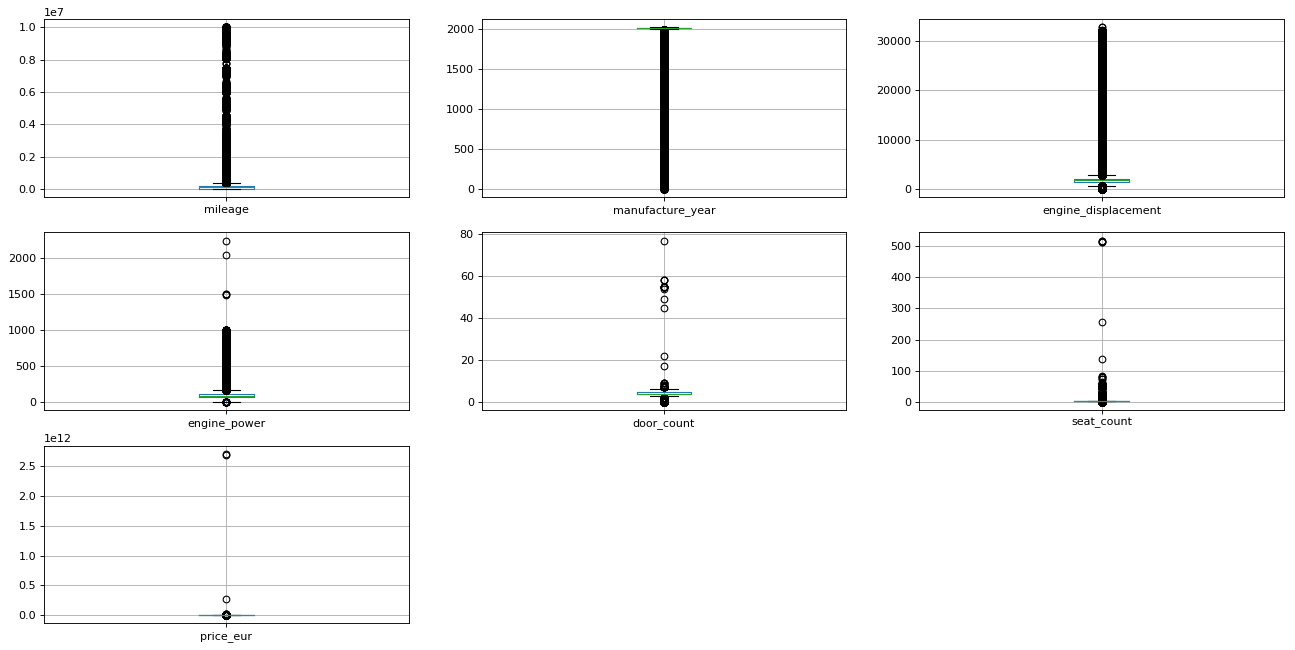

In [33]:
plt.show()

##### String variables description

In [ ]:
#display(Cars_DF.describe('maker','model','transmission','fuel_type'))

In [34]:
Cars_DF.describe('maker','model','transmission','fuel_type').toPandas()

,summary,maker,model,transmission,fuel_type
0,count,3033997,2419551,2811282,1705306
1,mean,None,500.5487669615217,None,None
2,stddev,None,864.5405757711787,None,None
3,min,alfa-romeo,100,auto,cng
4,max,volvo,zx,man,lpg


##### Distribution graphs for categorical variables

To analyze and explore our categorical variables we have used a distribution graph.  

In [35]:
groupedDF=Cars_DF.groupBy(["maker"]).agg(count(col("maker")).alias("count"))
DB2=groupedDF.sort(groupedDF["count"].desc()).toPandas()

In [36]:
fig, ax = plt.subplots(1, 1)
pd.plotting.table(ax, np.round(DB2.head(10), 2),loc='upper right', colWidths=[0.2, 0.2, 0.2])
DB2.plot(ax=ax, x='maker', y='count', kind='bar', legend=None, figsize=(10,5))

We have seen that the largest maker on our dataset is Skoda, followed by Volkswagen, and BMW. 

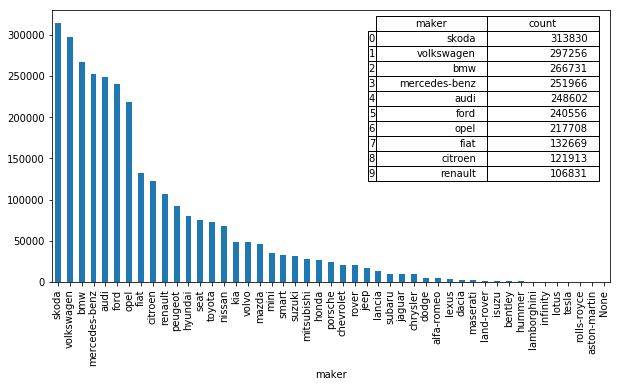

In [37]:
pl.show()

In [38]:
groupedDF=Cars_DF.groupBy(["model"]).agg(count(col("model")).alias("count"))
DB2=groupedDF.sort(groupedDF["count"].desc()).toPandas()
DB2=DB2.head(50)
fig, ax = plt.subplots(1, 1)
pd.plotting.table(ax, np.round(DB2.head(10), 2),loc='upper right', colWidths=[0.2, 0.2, 0.2])
DB2.plot(ax=ax, x='model', y='count', kind='bar', legend=None, figsize=(10,5))

The most popular model is the Octavia followed by the Fabia, and the least popular is the Galaxy.

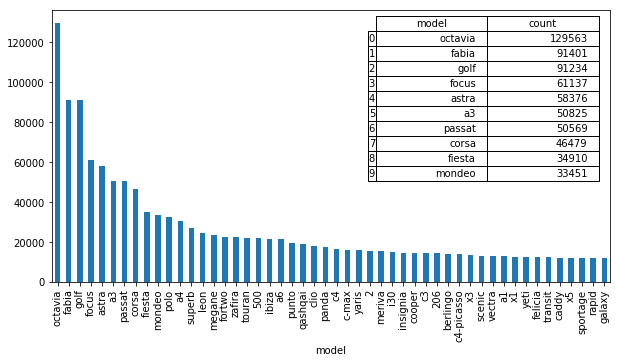

In [39]:
pl.show()

In [40]:
groupedDF=Cars_DF.groupBy(["transmission"]).agg(count(col("transmission")).alias("count"))
DB2=groupedDF.sort(groupedDF["count"].desc()).toPandas()
fig, ax = plt.subplots(1, 1)
pd.plotting.table(ax, np.round(DB2.head(10), 2),loc='upper right', colWidths=[0.2, 0.2, 0.2])
DB2.plot(ax=ax, x='transmission', y='count', kind='bar', legend=None, figsize=(10,5))

We can also see that there is a much larger number of manual transmission in comparison to automatic ones. This might be due to a cultural fact. 

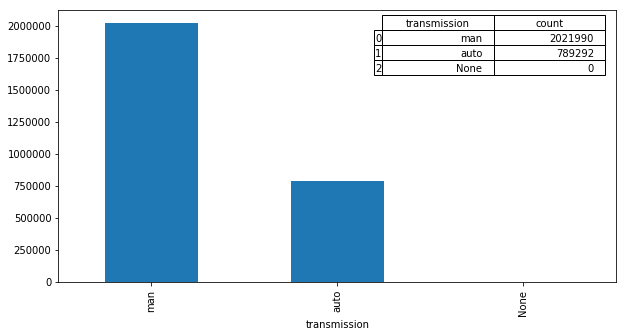

In [41]:
pl.show()

In [42]:
groupedDF=Cars_DF.groupBy(["fuel_type"]).agg(count(col("fuel_type")).alias("count"))
DB2=groupedDF.sort(groupedDF["count"].desc()).toPandas()
fig, ax = plt.subplots(1, 1)
pd.plotting.table(ax, np.round(DB2.head(10), 2),loc='upper right', colWidths=[0.2, 0.2, 0.2])
DB2.plot(ax=ax, x='fuel_type', y='count', kind='bar', legend=None, figsize=(10,5))

Most of the cars use diesel or gasoline as fuel type, and we can notice there are NA values

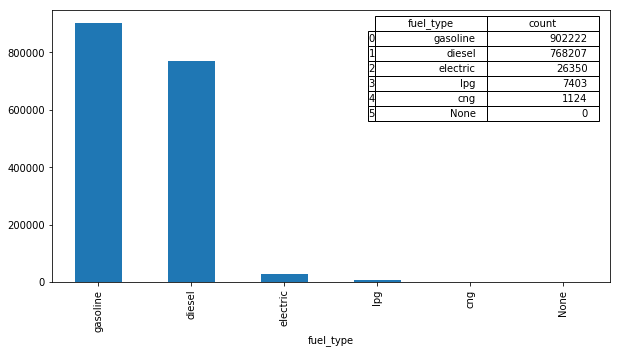

In [43]:
pl.show()

#### 2.2 Outliers Treatment

Now that we have seen which were the outliers through the boxplot we proceed to take them out to normalize it.  

In [44]:
Cars_DF =Cars_DF.filter(Cars_DF.mileage < 370000) 
Cars_DF =Cars_DF.filter(Cars_DF.manufacture_year > 1995) 
Cars_DF =Cars_DF.filter(Cars_DF.engine_displacement < 3000)
Cars_DF =Cars_DF.filter(Cars_DF.engine_displacement > 500)
Cars_DF =Cars_DF.filter(Cars_DF.door_count <= 6) 
Cars_DF =Cars_DF.filter(Cars_DF.door_count > 2)
Cars_DF =Cars_DF.filter(Cars_DF.seat_count < 10) 
Cars_DF =Cars_DF.filter(Cars_DF.seat_count > 2)
Cars_DF =Cars_DF.filter(Cars_DF.price_eur > 300)
Cars_DF =Cars_DF.filter(Cars_DF.price_eur < 40000)
Cars_DF =Cars_DF.filter(Cars_DF.engine_power < 180)
Cars_DF =Cars_DF.filter(Cars_DF.engine_power >10)
DB=Cars_DF.select('mileage','manufacture_year','engine_displacement',\
                             'engine_power','door_count','seat_count','price_eur').toPandas()


We repeat the boxplot analysis and we can see how the graph have improved in comparison to the previous ones.

In [45]:
plt.figure(figsize=(20,10),dpi=80)
plt.subplot(331)
DB.boxplot('mileage')
plt.subplot(332)
DB.boxplot('manufacture_year')
plt.subplot(333)
DB.boxplot('engine_displacement')
plt.subplot(334)
DB.boxplot('engine_power')
plt.subplot(335)
DB.boxplot('door_count')
plt.subplot(336)
DB.boxplot('seat_count')
plt.subplot(337)
DB.boxplot('price_eur')


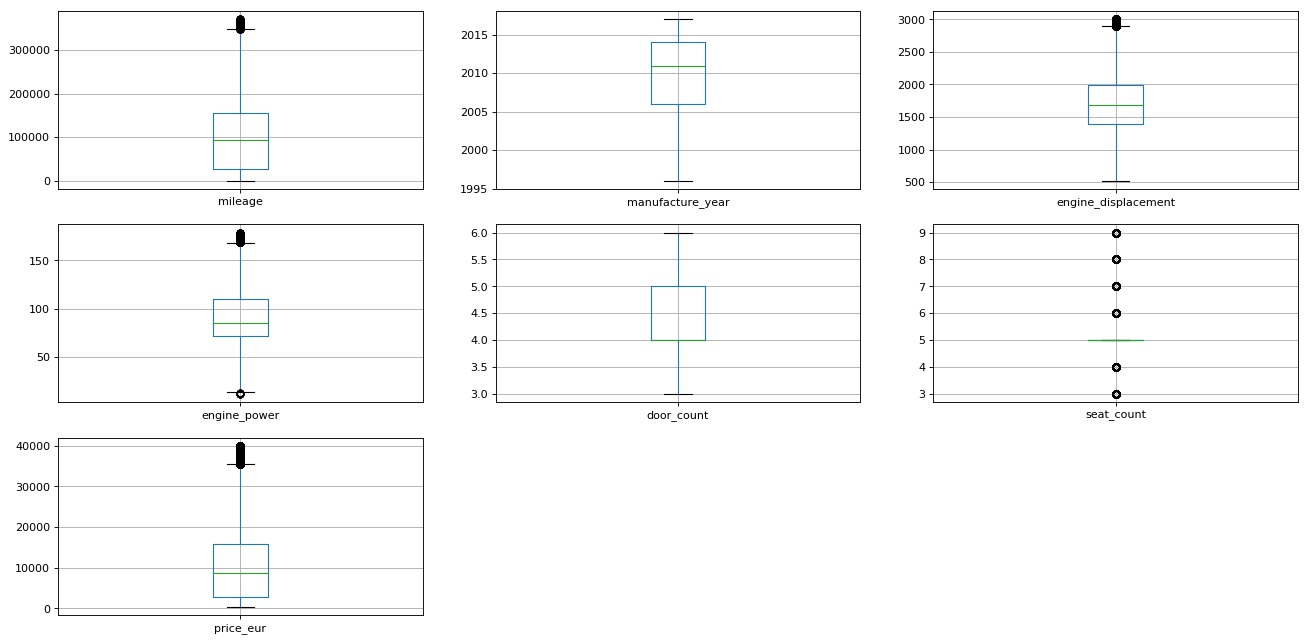

In [46]:
plt.show()

#### 2.3 Data Cleaning

As part of the data cleaning we will check for duplicate values and missing values NA to prepare the dataset for the analysis phase. We will count how many missing values we have per variable to be able to decide if we drop a variable or not depending on the number of missing values we have

In [ ]:
#display(Cars_DF.agg(*(countDistinct(col(c)).alias(c) for c in Cars_DF.columns)))

In [47]:
Cars_DF.agg(*(countDistinct(col(c)).alias(c) for c in Cars_DF.columns)).toPandas()

,id,maker,model,mileage,manufacture_year,engine_displacement,engine_power,transmission,door_count,seat_count,fuel_type,price_eur
0,1513193,39,685,203320,22,955,169,2,4,7,5,108476


We are going to check duplicates: we will compare counts of the our dataset with the folloing line (running distinct)


In [48]:
print('Count of rows: {0}'.format(Cars_DF.count()))

Count of rows: 1513193


In [49]:
print('Count of distinct rows: {0}'.format(Cars_DF.distinct().count()))

Count of distinct rows: 1513193


No Duplicates. 

We decide whether to drop or not based on the % of missed.


In [ ]:
#display(Cars_DF.agg(*[(1 - (F.count(c) / F.count('*'))).alias(c+ '_missing') for c in Cars_DF.columns]))

In [51]:
Cars_DF.agg(*[(1 - (F.count(c) / F.count('*'))).alias(c+ '_missing') for c in Cars_DF.columns]).toPandas().transpose()

,0
id_missing,0.000000
maker_missing,0.116216
model_missing,0.277339
mileage_missing,0.000000
manufacture_year_missing,0.000000
engine_displacement_missing,0.000000
engine_power_missing,0.000000
transmission_missing,0.051660
door_count_missing,0.000000
seat_count_missing,0.000000


Fuel_type_missing is 54% and model_missing is 27% so we need to explore more

In [52]:
ModelNA= Cars_DF.groupby('model', 'maker').count().orderBy('maker', ascending = True)
ModelNA.filter(col('model').isNull()).toPandas()

,model,maker,count
0,None,None,175857
1,None,alfa-romeo,16
2,None,audi,29205
3,None,bmw,82620
4,None,chevrolet,638
5,None,chrysler,28
6,None,citroen,88
7,None,dodge,3
8,None,fiat,3156
9,None,ford,3032


We can see in 175,857 cars, there is no mention of model or maker, so we drop these records

In [53]:
Cars_DF = Cars_DF.filter(Cars_DF.maker.isNotNull())

Then we drop the model column from our dataset since it won't be easy to replace or predict the missing values, then we see the impact on overall dataset

In [54]:
Cars_DF =Cars_DF.drop('model')
Cars_DF.agg(*[(1 - (F.count(c) / F.count('*'))).alias(c+ '_missing') for c in Cars_DF.columns]).toPandas().transpose()

,0
id_missing,0.000000
maker_missing,0.000000
mileage_missing,0.000000
manufacture_year_missing,0.000000
engine_displacement_missing,0.000000
engine_power_missing,0.000000
transmission_missing,0.057402
door_count_missing,0.000000
seat_count_missing,0.000000
fuel_type_missing,0.602504


We will drop as well the records with transmission_missing since it is only 5%

In [55]:
Cars_DF = Cars_DF.filter(Cars_DF.transmission.isNotNull())

Check again, we see there is now 63% missing on fuel_type

In [56]:
Cars_DF.agg(*[(1 - (F.count(c) / F.count('*'))).alias(c+ '_missing') for c in Cars_DF.columns]).toPandas().transpose()

,0
id_missing,0.000000
maker_missing,0.000000
mileage_missing,0.000000
manufacture_year_missing,0.000000
engine_displacement_missing,0.000000
engine_power_missing,0.000000
transmission_missing,0.000000
door_count_missing,0.000000
seat_count_missing,0.000000
fuel_type_missing,0.635017


So we explore more to make a decision about the missing values

In [57]:
FuelNA= Cars_DF.groupby('fuel_type').count().orderBy('fuel_type', ascending = True)
FuelNA.toPandas()

,fuel_type,count
0,None,800484
1,cng,444
2,diesel,247335
3,electric,6
4,gasoline,210970
5,lpg,1331


Finally, we replace the missing values in Fuel Type with 'others'. Then do a final check.

In [58]:
Cars_DF = Cars_DF.fillna({'fuel_type':'others'})

In [59]:
Cars_DF.agg(*[(1 - (F.count(c) / F.count('*'))).alias(c+ '_missing') for c in Cars_DF.columns]).toPandas().transpose()

,0
id_missing,0.0
maker_missing,0.0
mileage_missing,0.0
manufacture_year_missing,0.0
engine_displacement_missing,0.0
engine_power_missing,0.0
transmission_missing,0.0
door_count_missing,0.0
seat_count_missing,0.0
fuel_type_missing,0.0


#### 2.4 Creation Of New Variables 
As part of the exploratory analysis we have decided to create a new variable “buckets_price” which has four categories based on the price. The purpose of creating a new variable is to add more information that can make more accurate our models. 

In [60]:
Cars_DF.select([mean('price_eur'), min('price_eur'), max('price_eur')]).toPandas()

,avg(price_eur),min(price_eur),max(price_eur)
0,10907.609857,300.04,39999.0


 ##### Use binning in terms of pricing with 4 categories 
The price buckets mean 0.0:"Cheap", 1.0:"Normal", 2.0:"Good", 3.0:"TOP"

In [61]:
bucketizer = Bucketizer(splits=[ 0, 10000.0, 15000.0, 25000.0, float('Inf') ],
                        inputCol="price_eur", outputCol="buckets_price")
df_buck = bucketizer.setHandleInvalid("keep").transform(Cars_DF)

df_buck.cache()
Cars_DF.unpersist()

DataFrame[id: int, maker: string, mileage: int, manufacture_year: int, engine_displacement: int, engine_power: int, transmission: string, door_count: int, seat_count: int, fuel_type: string, price_eur: double]

In [62]:
df_buck.groupby('buckets_price').count().toPandas()

,buckets_price,count
0,0.0,680299
1,1.0,222611
2,3.0,98156
3,2.0,259504


### 3 - FEATURE SELECTION

This part is very important as the creation of features is what makes machine learning algorithms work. This is fundamental to the application of ML models. 

#### 3.1 Summary Statistics

Review the dataset again and make sure it is ready for the next steps 

In [63]:
df_nums = df_buck.drop('id','maker','transmission','fuel_type')
df_nums.cache()
df_nums = df_nums.toPandas()
df_nums.describe()

,mileage,manufacture_year,engine_displacement,engine_power,door_count,seat_count,price_eur,buckets_price
count,1.260570e+06,1.260570e+06,1.260570e+06,1.260570e+06,1.260570e+06,1.260570e+06,1.260570e+06,1.260570e+06
mean,1.003136e+05,2.009395e+03,1.745834e+03,9.150750e+01,4.379675e+00,5.050238e+00,1.090761e+04,8.219194e-01
std,7.802822e+04,4.946795e+00,4.336516e+02,2.911480e+01,5.999094e-01,6.383875e-01,8.684800e+03,1.012567e+00
min,0.000000e+00,1.996000e+03,5.200000e+02,1.100000e+01,3.000000e+00,3.000000e+00,3.000400e+02,0.000000e+00
25%,2.770000e+04,2.006000e+03,1.398000e+03,7.100000e+01,4.000000e+00,5.000000e+00,3.361510e+03,0.000000e+00
50%,9.217500e+04,2.010000e+03,1.686000e+03,8.800000e+01,4.000000e+00,5.000000e+00,9.030350e+03,0.000000e+00
75%,1.546000e+05,2.014000e+03,1.995000e+03,1.100000e+02,5.000000e+00,5.000000e+00,1.623161e+04,2.000000e+00
max,3.699990e+05,2.017000e+03,2.999000e+03,1.790000e+02,6.000000e+00,9.000000e+00,3.999900e+04,3.000000e+00


Understanding correlation among my variables, here we can see the dataset has more meaningful features 

In [64]:
df_nums.corr()

,mileage,manufacture_year,engine_displacement,engine_power,door_count,seat_count,price_eur,buckets_price
mileage,1.000000,-0.741943,0.376745,0.091953,0.030627,0.085502,-0.557073,-0.532575
manufacture_year,-0.741943,1.000000,-0.192677,0.113526,0.070773,-0.027370,0.650231,0.614107
engine_displacement,0.376745,-0.192677,1.000000,0.795087,-0.013052,0.181040,0.201246,0.194079
engine_power,0.091953,0.113526,0.795087,1.000000,-0.027439,0.136597,0.455683,0.442941
door_count,0.030627,0.070773,-0.013052,-0.027439,1.000000,0.122138,-0.063599,-0.039697
seat_count,0.085502,-0.027370,0.181040,0.136597,0.122138,1.000000,0.050953,0.059748
price_eur,-0.557073,0.650231,0.201246,0.455683,-0.063599,0.050953,1.000000,0.943240
buckets_price,-0.532575,0.614107,0.194079,0.442941,-0.039697,0.059748,0.943240,1.000000


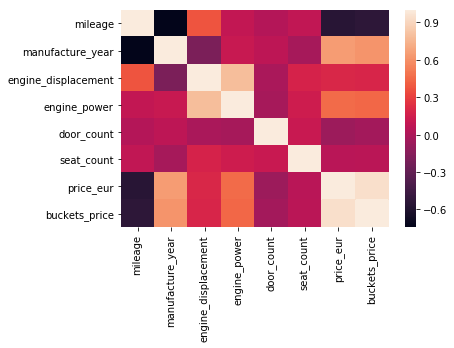

In [65]:
corr = df_nums.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

#### 3.2 Feature Engineering for Categorical Variables 

Here we will do Category Indexing with StringIndexer, then use OneHotEncoder to convert categorical variables into binary SparseVectors, finally Add stages.  These are not run here, but will run all at once later on

In [66]:
categoricalColumns = ['maker','transmission','fuel_type']
stages = [] # stages in our Pipeline
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol+"Index")
    encoder = OneHotEncoder(inputCol=categoricalCol+"Index", outputCol=categoricalCol+"classVec")
    stages += [stringIndexer, encoder]

Convert label into label indices using stringIndexer for Bucket_price

In [67]:
label_labelIdx = StringIndexer(inputCol = "buckets_price", outputCol = "label")
stages.append(label_labelIdx)

#### 3.3 Scaling Numerical Variables

In [68]:
numericCols = ['mileage', 'manufacture_year','engine_displacement','engine_power', 'door_count','seat_count']

stages.append(VectorAssembler(inputCols=numericCols, outputCol="numericalFeatures"))

stages.append(StandardScaler(withMean=True, withStd=True, inputCol="numericalFeatures",
                             outputCol="scaledNumericalFeatures"))

#### 3.4 Stacking Numerical Variables with Encoded Categorical Variables to Feature Vector

In [69]:
assemblerInputs = list(map(lambda c: c + "classVec", categoricalColumns))
assemblerInputs.append("scaledNumericalFeatures")
stages.append(VectorAssembler(inputCols=assemblerInputs, outputCol="features"))

In [70]:
stages

[StringIndexer_4347a1aa5c3188a44b02,
 OneHotEncoder_4c62b0916efedb4ca3bc,
 StringIndexer_4ed9a4a0bd05ea9668e8,
 OneHotEncoder_4fd18afa3104ac4a6ac6,
 StringIndexer_4cdabc7ff92765d40bf9,
 OneHotEncoder_4e479cde3f2f039dfab3,
 StringIndexer_48b59498517afd9c29de,
 VectorAssembler_480d9840c79747aaabf5,
 StandardScaler_435cac5540267177081e,
 VectorAssembler_472f892efa53d72b8f90]

#### 3.5 Creating Pipeline Estimator to Transform Input Dataset to Vectorized Dataset

To create the pipline, we will use fit() computes feature statistics as needed, then use transform() to actually transform the features. Finally, Keep relevant columns

In [71]:
cols = df_buck.columns
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(df_buck)
df_buck = pipelineModel.transform(df_buck)
# Keep relevant columns
selectedcols = ["label", "features"] + cols
df_pipline = df_buck.select(selectedcols)

In [72]:
df_pipline.cache()
df_buck.unpersist()

DataFrame[id: int, maker: string, mileage: int, manufacture_year: int, engine_displacement: int, engine_power: int, transmission: string, door_count: int, seat_count: int, fuel_type: string, price_eur: double, buckets_price: double, makerIndex: double, makerclassVec: vector, transmissionIndex: double, transmissionclassVec: vector, fuel_typeIndex: double, fuel_typeclassVec: vector, label: double, numericalFeatures: vector, scaledNumericalFeatures: vector, features: vector]

In [ ]:
#display(df_pipline)

In [73]:
df_pipline.show(5)

+-----+--------------------+---+-----+-------+----------------+-------------------+------------+------------+----------+----------+---------+---------+-------------+
|label|            features| id|maker|mileage|manufacture_year|engine_displacement|engine_power|transmission|door_count|seat_count|fuel_type|price_eur|buckets_price|
+-----+--------------------+---+-----+-------+----------------+-------------------+------------+------------+----------+----------+---------+---------+-------------+
|  2.0|(50,[2,38,40,44,4...|  0| ford| 151000|            2011|               2000|         103|         man|         5|         7|   diesel| 10584.75|          1.0|
|  0.0|(50,[1,38,40,44,4...|  1|skoda| 143476|            2012|               2000|          81|         man|         5|         5|   diesel|  8882.31|          0.0|
|  2.0|(50,[6,38,40,44,4...|  2|  bmw|  97676|            2010|               1995|          85|         man|         5|         5|   diesel| 12065.06|          1.0|
|  0

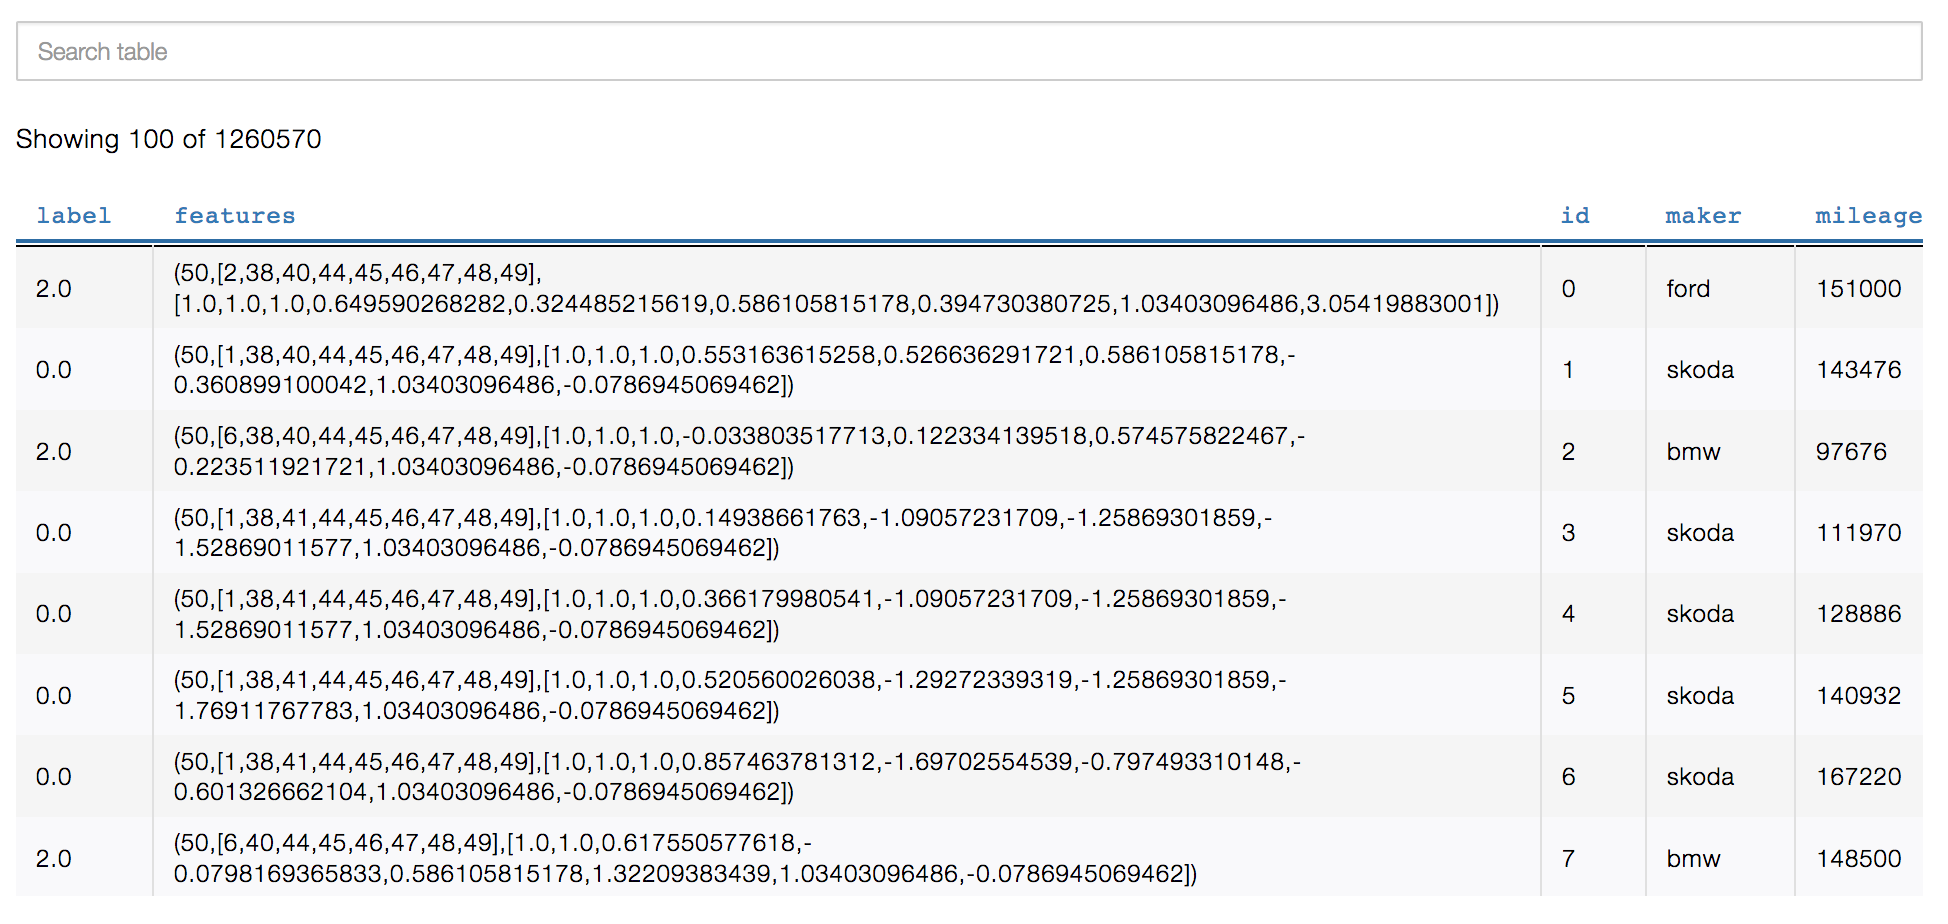

### 4 - MODEL TRAINING

After completing the previous steps, we will split the training and test dataframes to be able to train our model. 
We have decided to use a Logistic Regression, which is one of the most popular ML algorithms for classification. 
We train our model with the training dataframe and then we will test it with our test dataframe.  


#### 4.1 Splitting Training & Test Dataframes 

Randomly split data into training and test sets. set seed for reproducibility

In [74]:
(trainingData, testData) = df_pipline.randomSplit([0.7, 0.3], seed = 100)

print(trainingData.count())
print(testData.count())

881597
378973


#### 4.2 Training Logistic Regression on Vectorized Training Dataframe
Create initial LogisticRegression model, then Train model with Training Data

In [75]:
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
lrModel = lr.fit(trainingData)

#### 4.3 Prediction/Inference on Logistic Regression Model on Vectorized Test Dataframe
Make predictions on test data using the transform() method.
LogisticRegression.transform() will only use the 'features' column.

In [76]:
predictions = lrModel.transform(testData)

selected = predictions.select("label", "prediction", "probability")

In [ ]:
#display(selected)

In [77]:
selected.show(5)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.97502110102653...|
|  0.0|       0.0|[0.93313512374757...|
|  0.0|       0.0|[0.96082085232511...|
|  0.0|       0.0|[0.98943620903105...|
|  0.0|       0.0|[0.85824670799583...|
+-----+----------+--------------------+
only showing top 5 rows



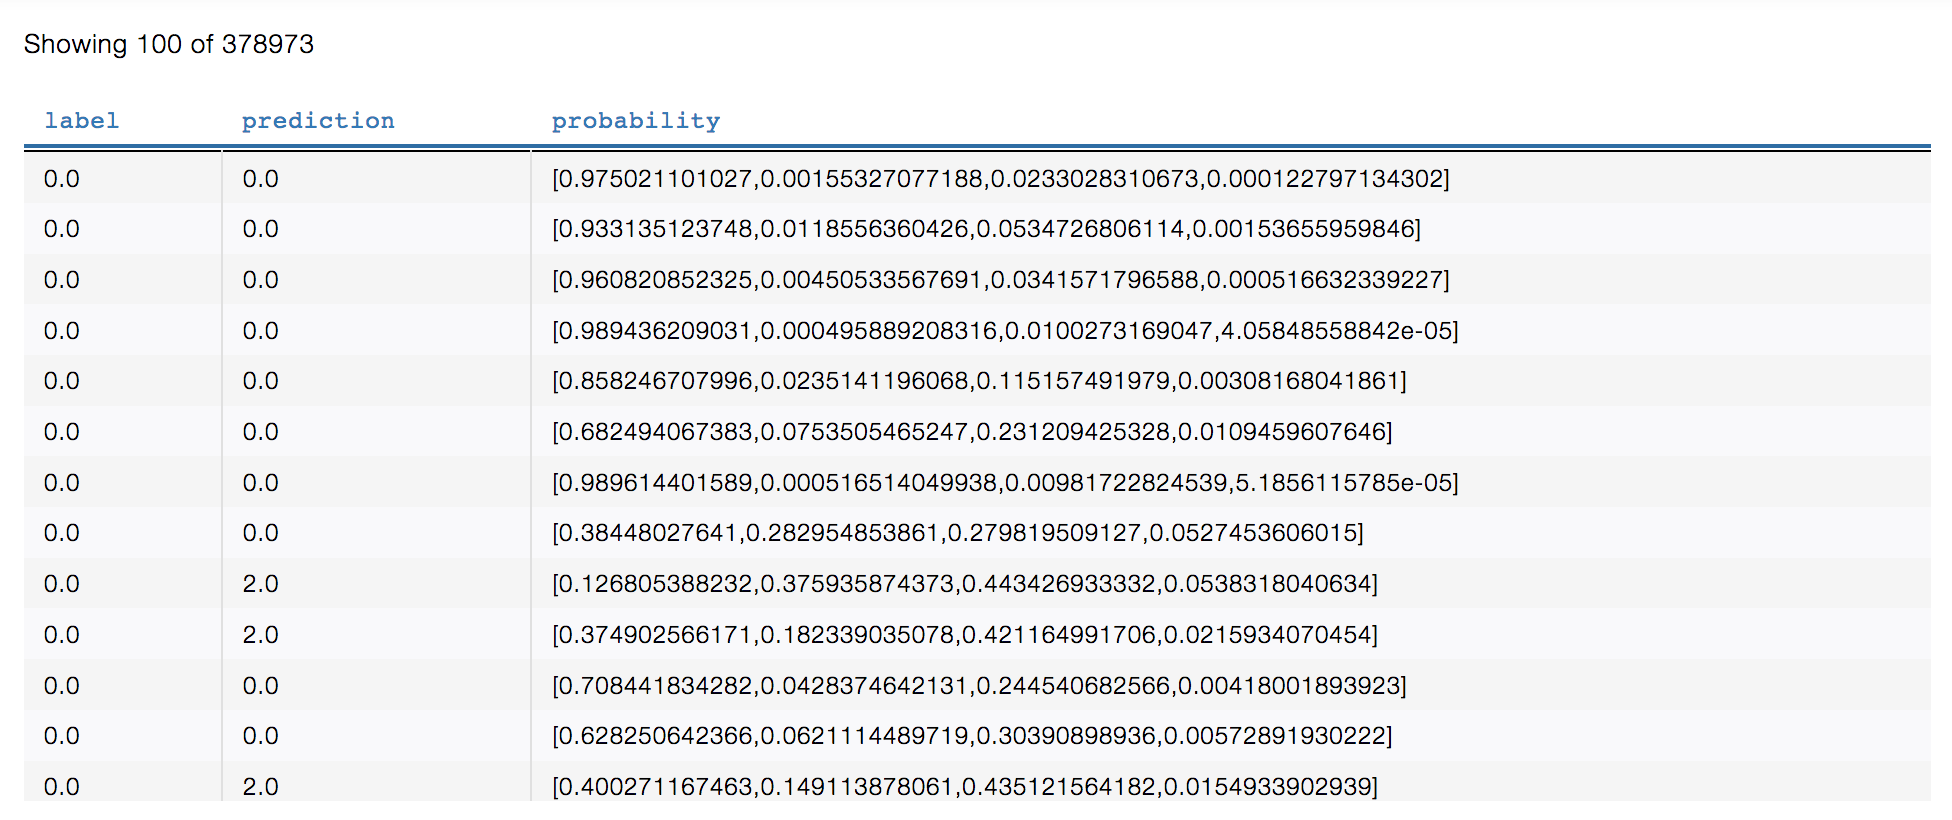

### 5 - Evaluating the Predictive Performance of Model Trained 
##### 5.1 Explicitly Over Evaluator

We have selected a ROC curve to evaluate the accuracy of our model, as it illustrates the diagnostic ability of a binary classifier system. The ROC curve can be used to select a threshold for a classifier that maximizes the true positives, while minimizing the false positives.

In [78]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

print(evaluator.getMetricName()+" : "+str(evaluator.evaluate(predictions)))
print(evaluator.explainParams())

areaUnderROC : 0.9511042956412571
labelCol: label column name. (default: label)
metricName: metric name in evaluation (areaUnderROC|areaUnderPR) (default: areaUnderROC)
rawPredictionCol: raw prediction (a.k.a. confidence) column name. (default: rawPrediction, current: rawPrediction)


We have obtained an accuracy of 95% looking at the test dataset

In [79]:
evaluationSummaryWithTest = lrModel.evaluate(testData)
evaluationSummaryWithTest.areaUnderROC

0.9498265766474302

In [ ]:
#display(evaluationSummaryWithTest.roc)

In [91]:
rocDataPandas=evaluationSummaryWithTest.roc.toPandas()

plt.title('Receiver Operating Characteristic')
plt.plot(rocDataPandas.FPR.values, rocDataPandas.TPR.values, 'b',
label='AUC = %0.2f'% evaluationSummaryWithTest.areaUnderROC)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


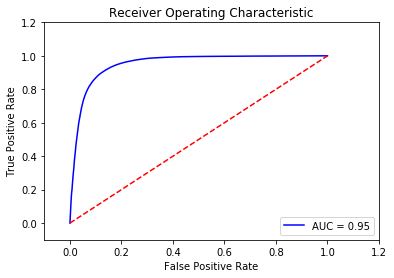

In [92]:
plt.show()

#### 5.2 Model Training by Cross-Validation
We have also done cross validation to evaluate the results of our prediction. we start with ParamGridBuilder

In [93]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

In [94]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
maxIter: max number of iterations (>= 0). (default: 100, current: 10)
predictionCol: prediction column name. (default: prediction)
probabilityCol: Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities. (default: probability)
rawPredictionCol: raw p

With the k-fold cross validation we have reduced the training dataframe into 5 subsets, so that each time one of the subsets is used as the test set. 

In [ ]:
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations
cvModel = cv.fit(trainingData)

# Setting bestModel according to Training Evaluation Performance
bestModel=cvModel.bestModel

#### 5.3 Evaluating the Predictive Performance of Model Trained by Cross-Validation
Use test set here so we can measure the accuracy of our model on new data

In [ ]:
Newpredictions = bestModel.transform(testData)

cvModel uses the best model found from the Cross Validation to Evaluate best model

In [ ]:
print(evaluator.getMetricName()+" : "+str(evaluator.evaluate(Newpredictions)))

weights = bestModel.coefficientMatrix

print("Model Coefficients:\n" weights.values)


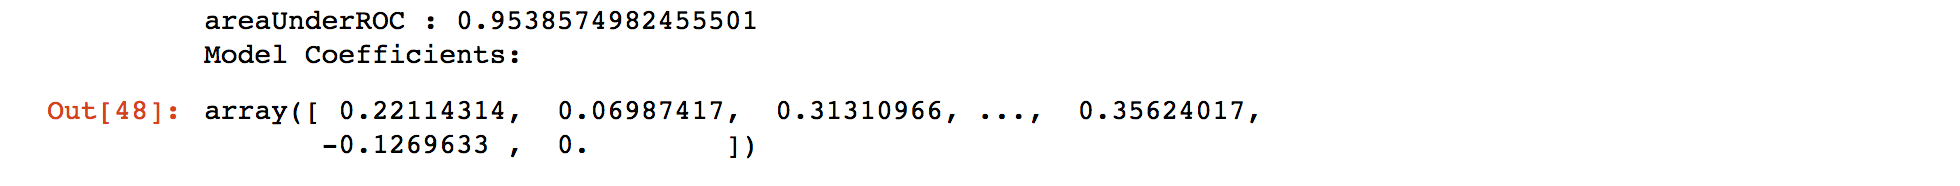

### 6 - Persisting Trained Models
We should also store Data Preprocessing & Feature Engineering stages in PipelineModel Transformer

In [ ]:
pipelineModel.write().overwrite().save("/models/pipelinemodel")

In [ ]:
!hdfs dfs -ls -R /models

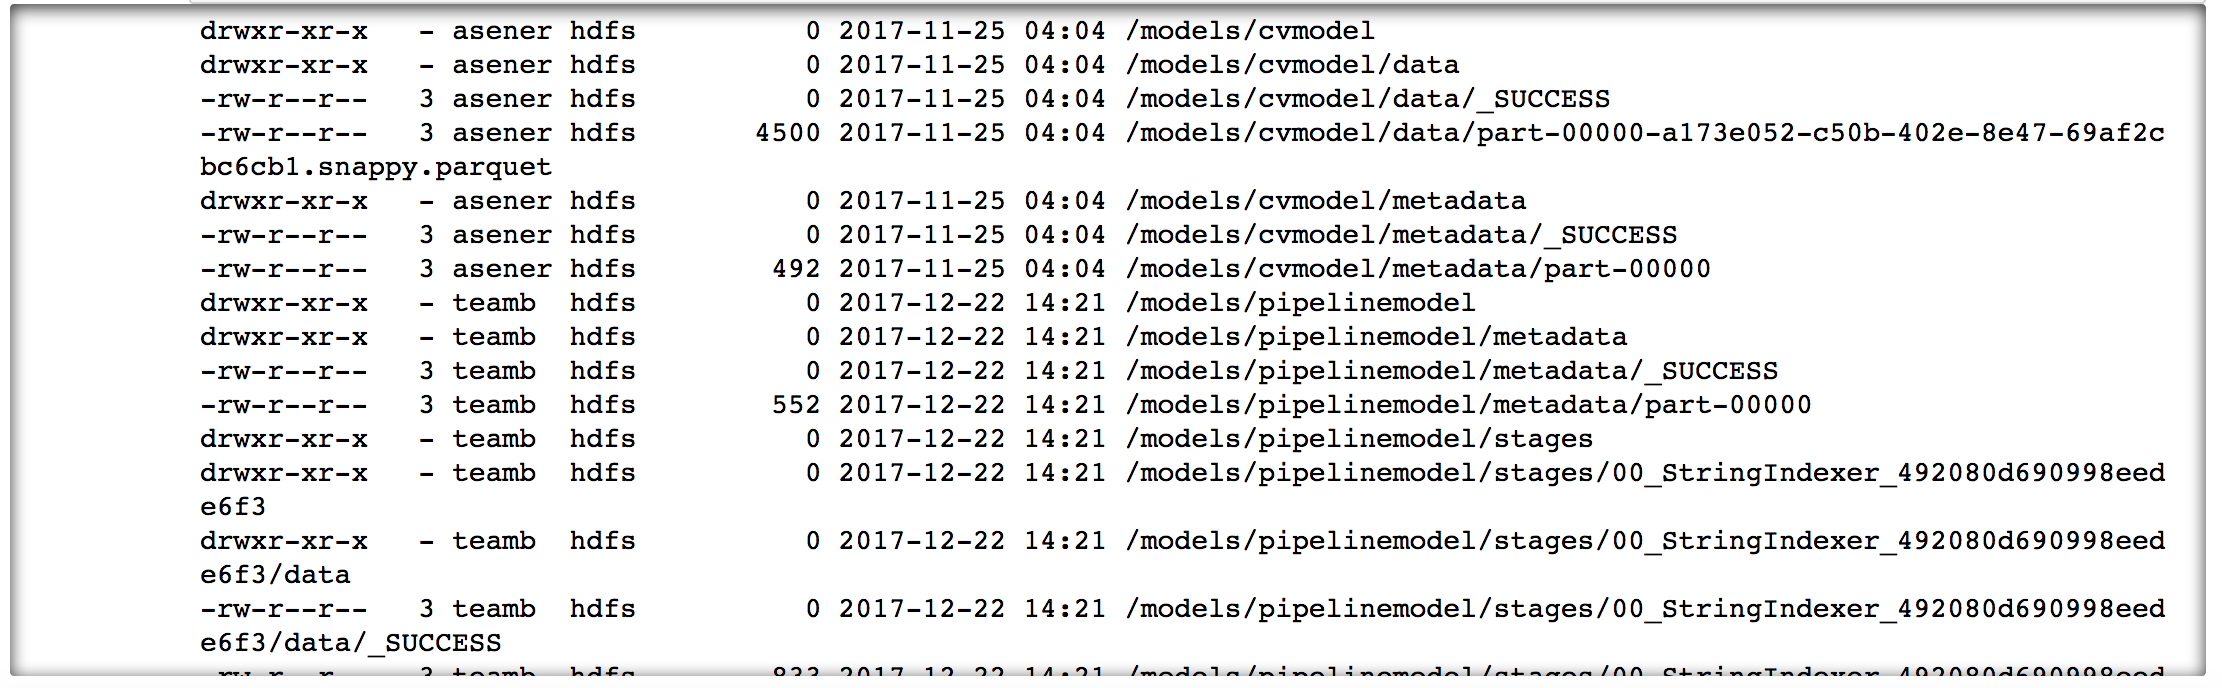

In [ ]:
spark.stop()

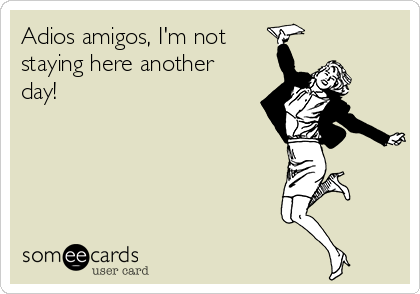